In [14]:
# implement DecisionTree with a fit and predict method
# Set up the skeleton for the DecisionTree class
import numpy as np
from sklearn.exceptions import NotFittedError
import copy
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_call, check_output
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as IPImage, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import io

np.random.seed(42)

class DecisionTree:
    def __init__(self, criterion='misclassification', max_depth=None, min_samples_split=2, min_samples_leaf=1):
        """
        Base classifier for a decision tree, that will be used for random forest and boosting.

        Parameters
        ----------
        criterion: str
            Either 'misclassification', 'gini', or 'entropy'.
        max_depth: int
            The maximum depth the tree should grow.
        min_samples_split: int
            The minimum number of samples required to split.
        min_samples_leaf: int
            The minimum number of samples required for a leaf node.
        """    
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
    
    def fit(self, X, y):
        """
        Fit the decision tree classifier.

        Parameters
        ----------
        X: numpy.ndarray
            The training data of size (n_samples, n_features).
        y: numpy.ndarray
            The labels of size (n_samples,).
        """
        self.n_features = X.shape[1]
        self.n_classes = len(np.unique(y))    

        self.tree = self._grow_tree(X, y, depth=0)

        return self

    def _grow_tree(self, X, y, depth=0):
        """
        Recursively 'grows' a decision tree.
        
        Parameters
        ----------
        X: numpy.ndarray
            The training data of size (n_samples, n_features).
        y: numpy.ndarray
            The labels of size (n_samples,).
        depth: int
            The current depth of the tree.
        """
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping conditions
        if(self.max_depth is not None and depth >= self.max_depth or
                n_samples < self.min_samples_split or 
                n_labels == 1):
            
            prediction = np.argmax(np.bincount(y))
            return Node(is_leaf = True, prediction = prediction) 

        # Find the best split
        feature_idx, threshold = self._best_split(X, y)

        # No split found, create a leaf node
        if feature_idx is None:
            prediction = np.argmax(np.bincount(y))
            return Node(is_leaf = True, prediction = prediction)

        # Split the data
        feature_values = X[:, feature_idx]
        left_idx = np.where(feature_values <= threshold)
        right_idx = np.where(feature_values > threshold)

        # Check min_samples_leaf constraint
        if len(left_idx[0]) < self.min_samples_leaf or len(right_idx[0]) < self.min_samples_leaf:
            prediction = np.argmax(np.bincount(y))
            return Node(is_leaf = True, prediction = prediction)

        # Recursively grow left and right subtree
        left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(feature_idx = feature_idx, threshold = threshold, left = left, right = right)
    
    def _best_split(self, X, y):
        """
        Find the best split for a node.
        
        Parameters
        ----------
        X: numpy.ndarray
            The training data of size (n_samples, n_features).
        y: numpy.ndarray
            The labels of the node.
        
        Returns
        -------
        tuple
            The index of the feature to split and the threshold to split on.
        """
        m = X.shape[0]
        if m <= 1:
            return None, None
    
        # Calculate the impurity for the parent
        parent_impurity = self._node_impurity(y)

        # Initialize the best split
        best_info_gain = -float('inf')
        best_feature_idx = None
        best_threshold = None

        for feature_idx in range(self.n_features):
            feature_values = X[:, feature_idx]
            thresholds = np.unique(feature_values)

            for threshold in thresholds:
                # Split the node
                left_idx = np.where(feature_values <= threshold)
                right_idx = np.where(feature_values > threshold)

                # if split violates min_samples_leaf constraint
                if len(left_idx[0]) < self.min_samples_leaf or len(right_idx[0]) < self.min_samples_leaf:
                    continue
                    
                # Calculate the impurity
                left_impurity = self._node_impurity(y[left_idx])
                right_impurity = self._node_impurity(y[right_idx])

                # Calculate the weights of the child nodes
                left_weight = len(left_idx[0]) / m
                right_weight = len(right_idx[0]) / m

                # Calculate the information gain
                info_gain = parent_impurity - (left_weight * left_impurity + right_weight * right_impurity)

                # Update if split is better
                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold

        return best_feature_idx, best_threshold

    def predict(self, X):
        """
        Predict the label of each sample in X. Note this is only for binary classification.
        
        Parameters
        ----------
        X: numpy.ndarray
            The training data of size (n_samples, n_features)."""
        if self.tree is None:
            raise NotFittedError('Estimator not fitted, call `fit` first.')
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _traverse_tree(self, x, node):
        """
        Traverse the tree to find the prediction for a given sample.
        
        Parameters
        ----------
        x: numpy.ndarray
            The sample of size (n_features,).
        node: Node
            The current node being evaluated.
        """
        # If leaf node, return the prediction
        if node.is_leaf is True:
            return node.prediction

        # Traverse left or right subtree
        if x[node.feature_idx] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

    def _node_impurity(self, y):
        """
        Compute the impurity of a node. 

        Parameters
        ----------

        y: numpy.ndarray
            The labels of the node.
        """

        if self.criterion == 'misclassification':
            miss_rate = 1 - np.max(np.bincount(y) / y.size)
            return miss_rate
        
        elif self.criterion == 'gini':
            gini = 1 - np.sum((np.bincount(y) / y.size) ** 2)
            return gini
        
        elif self.criterion == 'entropy':
            # include epislon to avoid log(0)
            epsilon = 1e-10
            p = np.bincount(y) / len(y)
            entropy = -np.sum(p * np.log2(p + epsilon))
            return entropy
        
        else:
            raise ValueError('Criterion should be "misclassification", "gini", or "entropy"')
     
    def _export_graphviz(self, out_file, feature_names=None, class_names=None, 
                       max_depth=None, rounded=False, filled=False):
        """
        Export the decision tree in DOT format.

        Parameters
        ----------
        out_file: file object
            Open file to write DOT file.
        feature_names: list of str, (optional)
            Names of the features.
        class_names: list of str, (optional)
            Names of the classes.
        max_depth: int, (optional)
            Max depth to export
        rounded: bool, (optional)
            If True rounds corners for the nodes.
        filled: bool, (optional)
            If True, colors in nodes. 
        """
        node_id_counter = [0]

        def recurse(node, depth):
            current_id = node_id_counter[0]
            node_id_counter[0] += 1

            # Base style attributes
            style = []
            if filled:
                style.append("filled")
            if rounded:
                style.append("rounded")
                
            style_attr = f'style="{",".join(style)}"' if style else ''

            if max_depth is not None and depth >= max_depth:
                label = "..."
                out_file.write(f'  {current_id} [label="{label}", shape=box, {style_attr}, color="lightgrey"];\n')
                return current_id

            if node.is_leaf:
                if class_names is not None:
                    label = f"Predict: {class_names[node.prediction]}"
                else:
                    label = f"Predict: {node.prediction}"
                color = 'lightblue' if filled else 'black'
                out_file.write(f'{current_id} [label="{label}", shape=box, {style_attr}, color="{color}"];\n')
            else:
                if feature_names is not None and node.feature_idx is not None:
                    feature = feature_names[node.feature_idx]
                else:
                    feature = f"X[{node.feature_idx}]"
                label = f"{feature} <= {node.threshold:.2f}"
                color = 'orange' if filled else 'black'
                out_file.write(f' {current_id} [label="{label}", {style_attr}, color="{color}"];\n')
                left_id = recurse(node.left, depth + 1)
                right_id = recurse(node.right, depth + 1)
                out_file.write(f" {current_id} -> {left_id} [label=\"yes\"];\n")
                out_file.write(f" {current_id} -> {right_id} [label=\"no\"];\n")
            return current_id

        out_file.write("digraph Tree {\n")
        if filled or rounded:
            out_file.write('node [shape=box, style="rounded,filled", color="black", fontname="helvetica"];\n')
        recurse(self.tree, 0)
        out_file.write("}\n")

    def export_and_visualize(self, dot_filename="tree.dot", png_filename="output.png",
                            title_text="Decision Tree", max_depth=3, feature_names=None,
                            class_names=None, rounded=True, filled=True):
        """
        Calls method to export tree to dot, converts dot to png via graphviz, 
        annotates the png, and displays the png.
        """
        # Export to DOT
        with open(dot_filename, 'w') as f:
            self._export_graphviz(f, 
                                max_depth=max_depth,
                                feature_names=feature_names,
                                class_names=class_names,
                                rounded=rounded,
                                filled=filled)

        # Convert to PNG
        png_bytes = check_output(['dot', '-Tpng', dot_filename])
       
        # Annotate and save
        with Image.open(io.BytesIO(png_bytes)) as img:
            draw = ImageDraw.Draw(img)
            try:
                font = ImageFont.truetype('arial.ttf', 26)
            except IOError:
                font = ImageFont.load_default()
                
            draw.text((10, 0), title_text, fill=(0, 0, 255), font=font)
            img.save(png_filename)
                
            # Display in notebook if available
            try:
                display(IPImage(filename=png_filename))
            except NameError:
                pass  # Running outside notebook
class Node:
    def __init__(self, is_leaf = False, feature_idx=None, threshold=None, left=None, right=None, prediction=None):
        """
        Node in decision tree
        
        Parameters
        ----------
        is_leaf: bool
            Whether the node is a leaf
        feature_idx: int
            Index of feature to split on
        threshold: float
            Value to split feature on
        left: Node
            Left child node
        right: Node
            Right child node
        Prediction: int or float
            Value at leaf node (class label)
        """
        self.is_leaf = is_leaf
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.prediction = prediction 

# Set up skeleton for RandomForest class
class RandomForest():
    def __init__(self, classifier, num_trees, min_features):
        """
        A random forest classifier that uses DecisionTree as the base classifier.
        
        Parameters
        ----------
        classifer: DecisionTree
            The classifier used as a base learner. An object of the DecisionTree class.
        num_trees: int
            The number of trees in the forest.
        min_features: int
            The minimum number of features to consider when looking
            for the best split.
        """
        self.classifier = classifier
        self.num_trees = num_trees
        self.min_features = min_features  
        self.trees = []   
    
    def fit(self, X, y):
        """
        Fit the random forest classifier.

        Parameters
        ----------

        X: numpy.ndarray
            The training data of size (n_samples, n_features).
        y: numpy.ndarray
            The labels of size (n_samples,).
        """
        n_samples, n_total_features = X.shape
        if self.min_features > n_total_features:
            raise ValueError('min_features must be less than or equal to the total number of features')
        
        self.trees = [] # clear out any previous trees
        for _ in range(self.num_trees):
            #bootstrap sample
            sample_indices = np.random.choice(n_samples, size = n_samples, replace = True)
            X_sample = X[sample_indices]
            y_sample = y[sample_indices]

            #random subset of features
            n = np.random.randint(self.min_features, n_total_features + 1)
            feature_indices = np.random.choice(n_total_features, size = n, replace=False)

            tree = copy.deepcopy(self.classifier)

            # subset of data
            X_sample_subset = X_sample[:, feature_indices]

            #fit tree
            tree.fit(X_sample_subset, y_sample)

            # store selected feature indices on tree for prediction
            tree.feature_indices = feature_indices
            self.trees.append(tree)
        
        return self
    
    def predict(self, X):
        """
        Predict the label of each sample in X. Note this is only for binary classification.
        
        Parameters
        ----------
        X: numpy.ndarray
            The training data of size (n_samples, n_features).
        """
        all_tree_predictions = []
        for tree in self.trees:
            X_subset = X[:, tree.feature_indices]
            predictions = tree.predict(X_subset)
            all_tree_predictions.append(predictions)

        all_tree_predictions = np.array(all_tree_predictions)

        # majority vote
        final_predictions = []
        for i in range(all_tree_predictions.shape[1]):
            votes = np.bincount(all_tree_predictions[:, i])
            final_predictions.append(np.argmax(votes))
        return np.array(final_predictions)

class AdaBoost():
    def __init__(self, weak_learner, num_learners, learning_rate):
        """
        An AdaBoost classifier that uses DecisionTree as the base classifier.
        
        Parameters
        ----------

        weak_learner: DecisionTree
            The classifier used as a weaker learner. An object of the DecisionTree class.
        num_learners: int
            The maximum number of learners to use when fitting the ensemble. If a perfect fit is 
            achieved before reaching this number, the predict method should stop early.
        learning_rate: float
            The weight applied to each weak learner per iteration.
        """
        super().__init__()
        self.weak_learner = weak_learner
        self.num_learners = num_learners
        self.learning_rate = learning_rate
        self.alphas = [] # list of learner weights
        self.learners = []
        self.is_fitted = False
    
    def fit(self, X, y):
        """
        Fit the AdaBoost classifier.

        Parameters
        ----------
        X: numpy.ndarray
            The training data of size (n_samples, n_features).
        y: numpy.ndarray
            The labels of size (n_samples,).
        """
        n_samples = X.shape[0]

        # Transform labels to -1 and 1
        y_transformed = np.copy(y)
        unique_labels = np.unique(y)
        if np.array_equal(unique_labels, np.array([0, 1])):
            y_transformed = 2 * y_transformed - 1
        elif np.array_equal(unique_labels, np.array([-1, 1])):
            pass
        else:
            raise ValueError('Labels must be in {0, 1} or {-1, 1}')
    
        # Initialize weights
        weights = np.ones(n_samples) / n_samples

        self.learners = [] 
        self.alphas = []

        for _ in range(self.num_learners):
            # create a copy of the weak learner
            learner = copy.deepcopy(self.weak_learner)

            # normalize weights to probabilities
            probabilties = weights / np.sum(weights)

            # sample with replacement according to weights
            sample_indices = np.random.choice(n_samples, size = n_samples, replace = True, p = probabilties)
            X_sample = X[sample_indices]
            y_sample = y_transformed[sample_indices]

            # convert to 0, 1 labels for weak learner (DecisionTree)
            y_sample = (y_sample + 1) // 2

            # fit the weak learner
            learner.fit(X_sample, y_sample)

            # make predictions and convert to -1, 1 labels
            predictions = learner.predict(X)
            predictions = 2 * predictions - 1

            # calculate weighted error
            misclassified = predictions != y_transformed
            weighted_error = np.sum(weights * misclassified) / np.sum(weights)

            # if error is >= 0.5 then break early (weak learner is worse than random guessing)
            if weighted_error >= 0.5:
                break
            if weighted_error < 1e-10:
                ##alpha = self.learning_rate * 0.5 np.log((1 - 1e-10) / 1e-10)
                alpha = self.learning_rate * np.log((1 - 1e-10) / 1e-10)

                self.alphas.append(alpha)
                self.learners.append(learner)
                break

            # calculate alpha
            ##alpha = self.learning_rate * 0.5 * np.log((1 - weighted_error) / weighted_error)
            alpha = self.learning_rate * np.log((1 - weighted_error) / weighted_error)

            # update weights
            ## weights *= np.exp(-alpha * y_transformed * predictions)
            weights *= np.exp(alpha * (y_transformed != predictions))

            # normalize weights
            weights /= np.sum(weights)

            # store alpha and learner
            self.alphas.append(alpha)
            self.learners.append(learner)
        
        self.is_fitted = True
        return self
    def predict(self, X):
        """
        Predict the label of each sample in X. Note this is only for binary classification.
        
        Parameters
        ----------
        X: numpy.ndarray
            The training data of size (n_samples, n_features).
        """
        if not self.is_fitted:
            raise NotFittedError('Estimator not fitted, call `fit` first.')
        
        prediction_scores = np.zeros(X.shape[0])
        for alpha, learner in zip(self.alphas, self.learners):
            predictions = learner.predict(X)
            predictions = 2 * predictions - 1
            prediction_scores += alpha * predictions

        return np.sign(prediction_scores)

# Preparing the Titanic Dataset

In [2]:
import pandas as pd

# Loading the data
X_train = pd.read_csv('train.csv')
y_train = X_train["Survived"]

X_test = pd.read_csv('test.csv')


# Store test passenger IDs for easy access
PassengerId = X_test['PassengerId']

X_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
# Copy original dataset in case we need it later when digging into interesting features
# WARNING: Beware of actually copying the dataframe instead of just referencing it
# "original_train = train" will create a reference to the train variable (changes in 'train' will apply to 'original_train')
original_train = X_train.copy() # Using 'copy()' allows to clone the dataset, creating a different object with the same values

# Feature engineering steps taken from Sina and Anisotropic, with minor changes to avoid warnings
full_data = [X_train, X_test]

# Feature that tells whether a passenger had a cabin on the Titanic
X_train['Has_Cabin'] = X_train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
X_test['Has_Cabin'] = X_test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(X_train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

<>:39: SyntaxWarning: invalid escape sequence '\.'
<>:39: SyntaxWarning: invalid escape sequence '\.'
C:\Users\ed5ch\AppData\Local\Temp\ipykernel_31472\2198639818.py:39: SyntaxWarning: invalid escape sequence '\.'
  title_search = re.search(' ([A-Za-z]+)\.', name)


In [4]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Survived']
X_train = X_train.drop(drop_elements, axis = 1)


In [5]:
X_train.head(3)

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,1,0,0,0,0,2,0,1
1,1,0,2,0,3,1,1,2,0,3
2,3,0,1,0,1,0,0,1,1,4


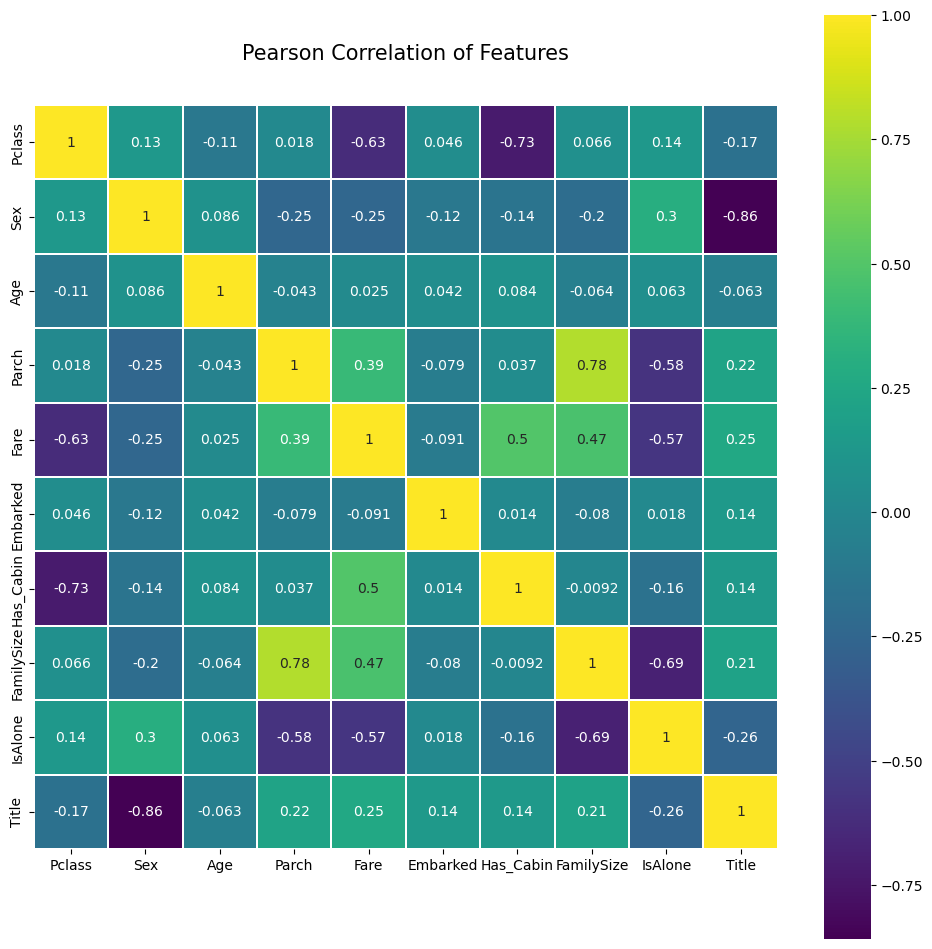

In [6]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [9]:
dt = DecisionTree(criterion='gini', max_depth = 5)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)

In [10]:
dt_acc

0.8268156424581006

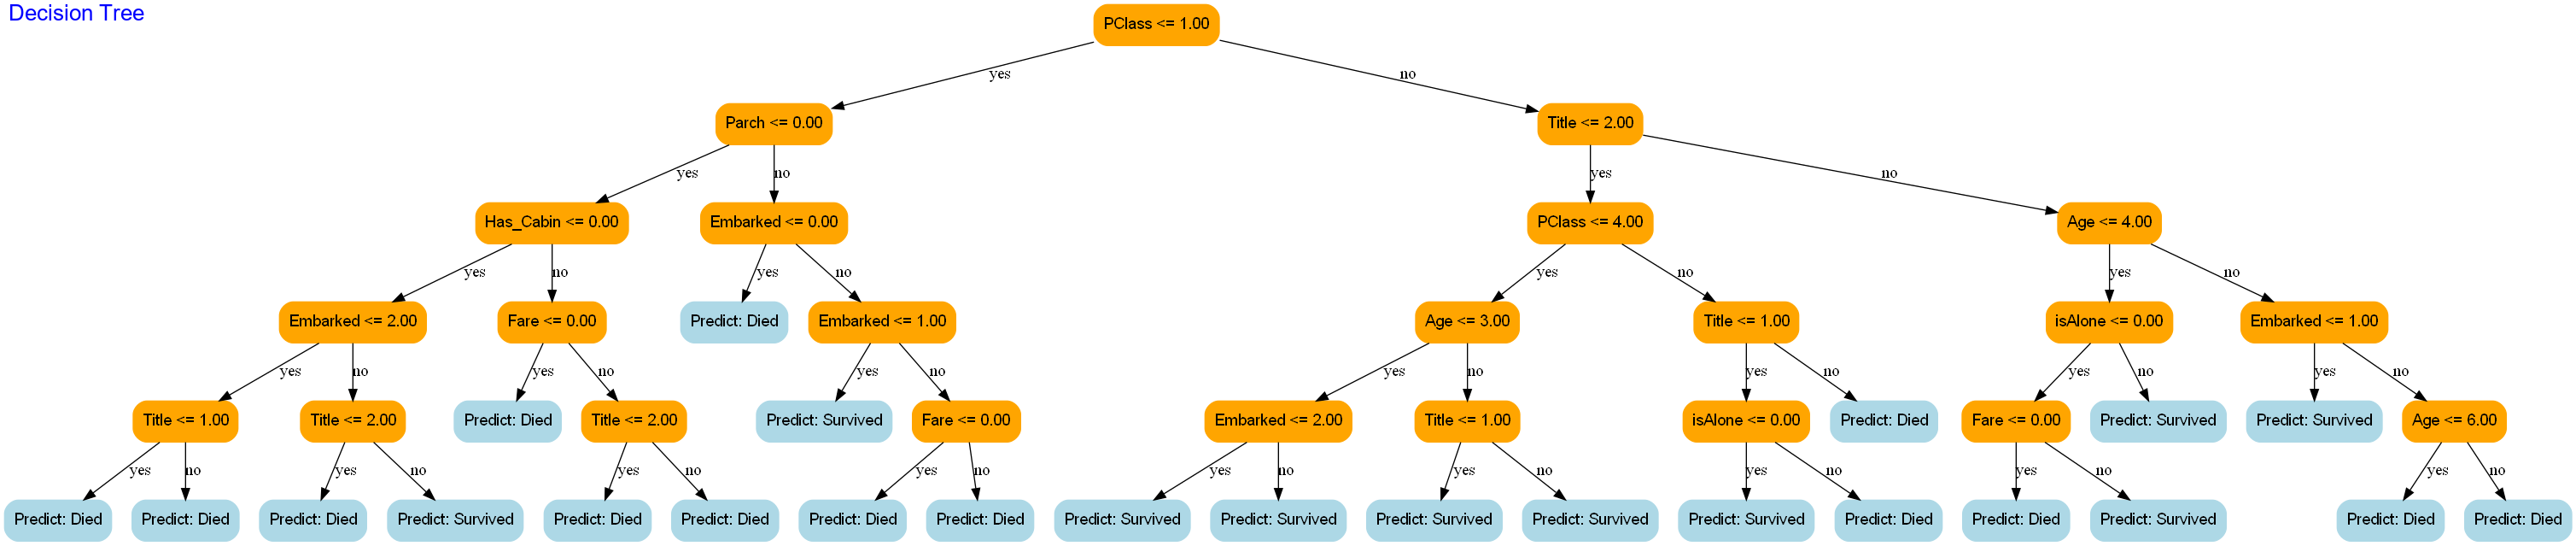

In [15]:
# with open('dt_tree.dot', 'w') as f:
#     dt.export_graphviz(f, feature_names = ['Title', 'isAlone', 'FamilySize', 'Has_Cabin', 'Embarked', 'Fare', 'Parch', 'Age', 'Sex', 'PClass'], class_names=['Died', 'Survived'], max_depth = None)
# dt.annotate_and_display("dt_tree.dot", "dt_tree.png", 'Decision Tree')

dt.export_and_visualize(dot_filename='dt_tree.dot', png_filename='dt_tree.png', title_text='Decision Tree',  feature_names=['Title', 'isAlone', 'FamilySize', 'Has_Cabin', 'Embarked', 'Fare', 'Parch', 'Age', 'Sex', 'PClass'], class_names=['Died', 'Survived'], max_depth = None)


In [16]:
rf = RandomForest(classifier=DecisionTree(criterion='gini', max_depth = 5), num_trees = 10, min_features = 2)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

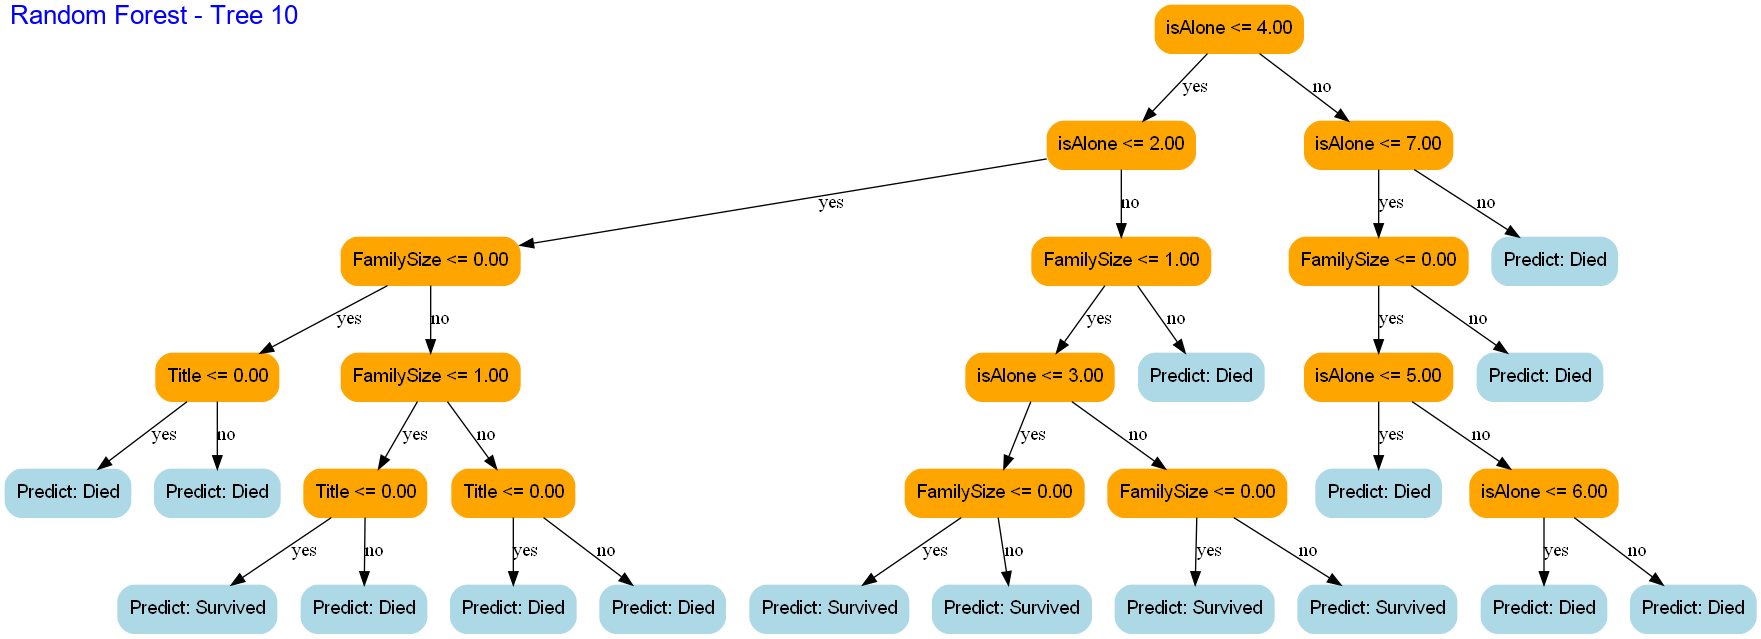

In [17]:
first_rf_tree = rf.trees[9]
# with open('rf_tree.dot', 'w') as f:
#     first_rf_tree.export_graphviz(f, feature_names = ['Title', 'isAlone', 'FamilySize', 'Has_Cabin', 'Embarked', 'Fare', 'Parch', 'Age', 'Sex', 'PClass'], class_names=['Died', 'Survived'], max_depth = None)
# first_rf_tree.annotate_and_display('rf_tree.dot', 'rf_tree.png', 'Random Forest - Tree 1')
first_rf_tree.export_and_visualize(dot_filename='rf_tree.dot', png_filename='rf_tree.png', title_text='Random Forest - Tree 10',  feature_names=['Title', 'isAlone', 'FamilySize', 'Has_Cabin', 'Embarked', 'Fare', 'Parch', 'Age', 'Sex', 'PClass'], class_names=['Died', 'Survived'], max_depth = None)


In [18]:
rf_acc

0.8156424581005587

In [19]:
ab = AdaBoost(weak_learner = DecisionTree(criterion='gini', max_depth=5), num_learners = 50, learning_rate=1.0)
ab.fit(X_train, y_train)
ab_pred = ab.predict(X_test)
ab_pred = np.where(ab_pred == 1, 1, 0)
ab_acc = accuracy_score(y_test, ab_pred)

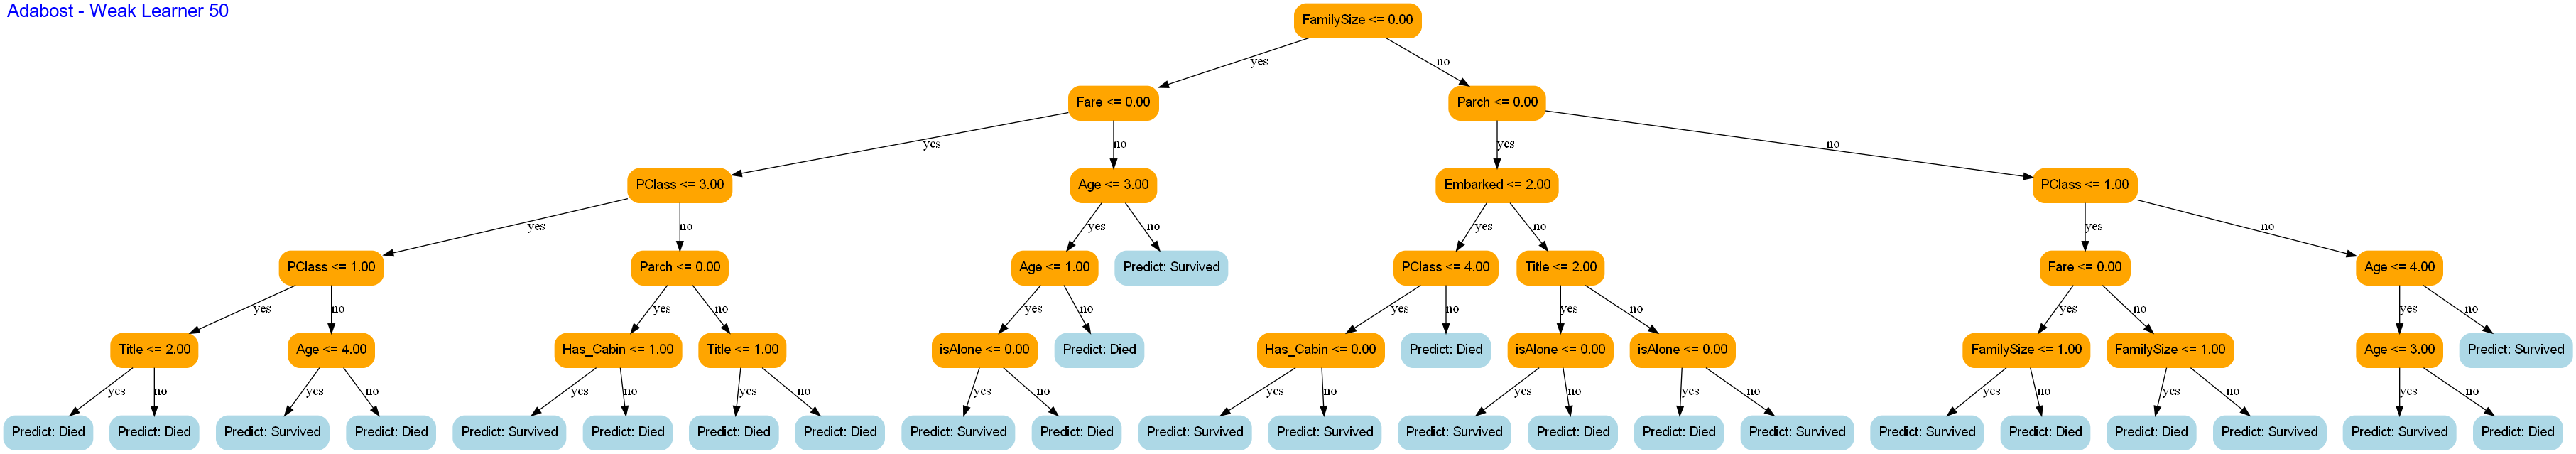

In [20]:
first_ab_tree = ab.learners[49]
# with open('ab_tree.dot', 'w') as f:
#     first_ab_tree.export_graphviz(f, feature_names = ['Title', 'isAlone', 'FamilySize', 'Has_Cabin', 'Embarked', 'Fare', 'Parch', 'Age', 'Sex', 'PClass'], class_names=['Died', 'Survived'], max_depth = None)
# first_ab_tree.annotate_and_display('ab_tree.dot', 'ab_tree.png', 'AdaBoost - Weak Learner 1')
first_ab_tree.export_and_visualize(dot_filename='ab_tree.dot', png_filename='ab_tree.png', title_text='Adabost - Weak Learner 50',  feature_names=['Title', 'isAlone', 'FamilySize', 'Has_Cabin', 'Embarked', 'Fare', 'Parch', 'Age', 'Sex', 'PClass'], class_names=['Died', 'Survived'], max_depth = None)


In [21]:
ab_acc

0.8547486033519553

In [22]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'AdaBoost'],
    'Test Accuracy': [dt_acc, rf_acc, ab_acc]
})
results

,Model,Test Accuracy
0,Decision Tree,0.826816
1,Random Forest,0.815642
2,AdaBoost,0.854749
